## Structuring the Data

In [4]:
import tarfile
import os
import shutil
file = tarfile.open('cloudy_images/LC09_L2SP_015043_20220305_20220307_02_T1.tar')
file.extractall('./cloudy_images/')
file.close()

## Considering First 7 Bands of a Given Satellite Image
for elem in os.listdir('cloudy_images/'):
    ans = False
    for i in range(1, 8):
        if f'B{i}' in elem and f'B10' not in elem:
            ans = True
            break
    if not ans : os.remove(f'./cloudy_images/{elem}')



In [8]:
for index,elem in enumerate(os.listdir('ground_truth/')):
    os.makedirs(f'ground_truth/scene{index + 1}/original_image/')
    file = tarfile.open(f'ground_truth/{elem}')
    file.extractall(f'ground_truth/scene{index + 1}/original_image/')
    for image in os.listdir(f'ground_truth/scene{index + 1}/original_image/'):
        ans = False
        for i in range(1, 8):
            if f'B{i}' in image and f'B10' not in image : 
                ans = True
                break
        if not ans : os.remove(f'ground_truth/scene{index + 1}/original_image/{image}')


In [1]:
import os 

In [2]:
import cv2
## Function to Resize Images to (512, 512)
def resize_images(path):
    original_image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    new_image = cv2.resize(original_image,(512,512))
    os.remove(path)
    cv2.imwrite(path,new_image)



In [3]:
for elem in os.listdir('cloudy_images/'):
    resize_images(f'cloudy_images/{elem}')


In [4]:
for elem in os.listdir('ground_truth/'):
    for image in os.listdir(f'ground_truth/{elem}/original_image/'):
        resize_images(f'ground_truth/{elem}/original_image/{image}')

## Trying to Form RGB Image for Cloudy and Non Cloudy Image using Bands 2, 3, 4

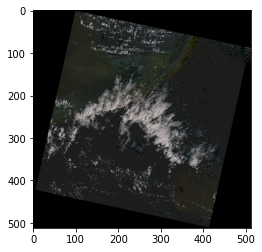

In [12]:
from matplotlib import pyplot as plt
## Function to Display RGB Image of a Dataset
def showRGB(b2, b3, b4):
    img2 = cv2.imread(b2,cv2.IMREAD_GRAYSCALE)
    img3 = cv2.imread(b3,cv2.IMREAD_GRAYSCALE)
    img4 = cv2.imread(b4,cv2.IMREAD_GRAYSCALE)
    
    final_image = cv2.merge((img2,img3,img4))
    plt.imshow(final_image)
    plt.show()

    
showRGB('./cloudy_images/LC09_L2SP_015043_20220305_20220307_02_T1_SR_B2.TIF','./cloudy_images/LC09_L2SP_015043_20220305_20220307_02_T1_SR_B3.TIF',
       './cloudy_images/LC09_L2SP_015043_20220305_20220307_02_T1_SR_B4.TIF')

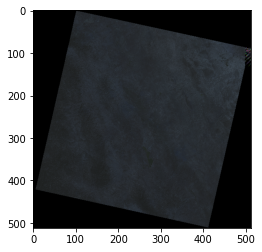

In [15]:
showRGB('./ground_truth/scene1/original_image/LC09_L2SP_031042_20220305_20220307_02_T1_SR_B2.TIF',
        './ground_truth/scene1/original_image/LC09_L2SP_031042_20220305_20220307_02_T1_SR_B3.TIF',
       './ground_truth/scene1/original_image/LC09_L2SP_031042_20220305_20220307_02_T1_SR_B4.TIF')

## Apply Non Linear Min Filter to Cloudy Images

In [18]:
import numpy as np
## Function to Apply Non Linear Min Filtering to Cloudy Images
def non_linear_min_filter(path):
    image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    size = (3, 3)
    shape = cv2.MORPH_RECT
    kernel = cv2.getStructuringElement(shape, size)
    kernel = np.ones((3,3),dtype = np.uint8)
    min_image = cv2.erode(image, kernel)
    os.remove(path)
    cv2.imwrite(path,min_image)
    
for image in os.listdir('cloudy_images/'):
    non_linear_min_filter(f'cloudy_images/{image}')

## Find Values of Alpha using Linear Regression

In [20]:
a = os.listdir('cloudy_images/')
a.remove('LC09_L2SP_015043_20220305_20220307_02_T1_SR_B1.TIF')
print(a)

['LC09_L2SP_015043_20220305_20220307_02_T1_SR_B2.TIF', 'LC09_L2SP_015043_20220305_20220307_02_T1_SR_B3.TIF', 'LC09_L2SP_015043_20220305_20220307_02_T1_SR_B4.TIF', 'LC09_L2SP_015043_20220305_20220307_02_T1_SR_B5.TIF', 'LC09_L2SP_015043_20220305_20220307_02_T1_SR_B6.TIF', 'LC09_L2SP_015043_20220305_20220307_02_T1_SR_B7.TIF']


In [21]:
from sklearn.linear_model import LinearRegression
alpha_values = []
for elem in a:
    xo = cv2.imread('cloudy_images/LC09_L2SP_015043_20220305_20220307_02_T1_SR_B1.TIF',cv2.IMREAD_GRAYSCALE)/255
    x1 = cv2.imread(f'cloudy_images/{elem}',cv2.IMREAD_GRAYSCALE)/255
    xo = xo.flatten()
    x1 = x1.flatten()
    xo = xo.reshape(-1,1)
    x1 = x1.reshape(-1,1)
    reg = LinearRegression().fit(xo,x1)
    alpha_values.append(reg.coef_[0][0])
    print(reg.coef_[0][0])

1.0009932399477433
0.9454578504535368
0.9228110587061803
0.9041695091235005
0.6084343409287072
0.49031113432043844


In [22]:
alpha_values

[1.0009932399477433,
 0.9454578504535368,
 0.9228110587061803,
 0.9041695091235005,
 0.6084343409287072,
 0.49031113432043844]

In [23]:
alpha_values = [1] + alpha_values
print(alpha_values)

[1, 1.0009932399477433, 0.9454578504535368, 0.9228110587061803, 0.9041695091235005, 0.6084343409287072, 0.49031113432043844]


## Trying to Generate a sample Image using B2_Bannd Ground Truth Image and Value of Alpha

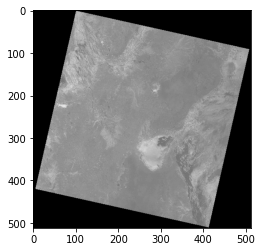

In [25]:
xo = cv2.imread('cloudy_images/LC09_L2SP_015043_20220305_20220307_02_T1_SR_B1.TIF',cv2.IMREAD_GRAYSCALE)/255
original_image = cv2.imread('ground_truth/scene5/original_image/LC09_L2SP_097078_20220304_20220306_02_T1_SR_B1.TIF',cv2.IMREAD_GRAYSCALE)/255
plt.imshow(original_image,cmap='gray')
plt.show()

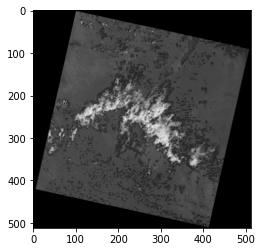

In [34]:
cloudy_synthetic_image = original_image + alpha_values[1]*xo
plt.imshow(cloudy_synthetic_image,cmap='gray')
plt.show()

## Generate Synthetic Cloud Images for All Scenes

In [36]:
for elem in os.listdir('ground_truth/'):
    os.makedirs(f'ground_truth/{elem}/synthetic_cloud_images/')

        

In [46]:
for index,elem in enumerate(os.listdir('ground_truth/')):
    for ind,image in enumerate(os.listdir(f'ground_truth/scene{index + 1}/original_image/')):
        xo = cv2.imread('cloudy_images/LC09_L2SP_015043_20220305_20220307_02_T1_SR_B1.TIF',cv2.IMREAD_GRAYSCALE)/255
        original_image = cv2.imread(f'ground_truth/scene{index + 1}/original_image/{image}',cv2.IMREAD_GRAYSCALE)/255
        cloudy_image = original_image + alpha_values[ind]*xo
        new_array = []
        for elem in cloudy_image: 
            row = []
            for el in elem : 
                row.append(int(el*255))
        new_array.append(row)
        new_array = np.array(new_array)
        cv2.imwrite(f'ground_truth/scene{index + 1}/synthetic_cloud_images/{image}',new_array)

## Generating an RGB image of Synthetic Cloud Image

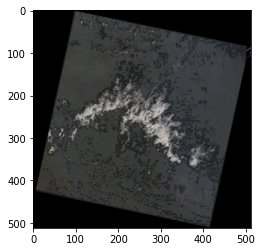

In [48]:
showRGB('ground_truth/scene14/synthetic_cloud_images/LC09_L2SP_145051_20220304_20220306_02_T1_SR_B2.TIF',
       'ground_truth/scene14/synthetic_cloud_images/LC09_L2SP_145051_20220304_20220306_02_T1_SR_B3.TIF',
       'ground_truth/scene14/synthetic_cloud_images/LC09_L2SP_145051_20220304_20220306_02_T1_SR_B4.TIF')

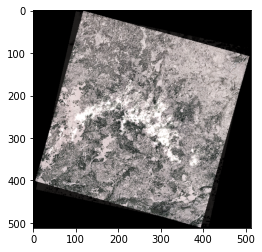

In [50]:
showRGB('ground_truth/scene3/synthetic_cloud_images/LC09_L2SP_033020_20220303_20220305_02_T1_SR_B2.TIF',
       'ground_truth/scene3/synthetic_cloud_images/LC09_L2SP_033020_20220303_20220305_02_T1_SR_B3.TIF',
       'ground_truth/scene3/synthetic_cloud_images/LC09_L2SP_033020_20220303_20220305_02_T1_SR_B4.TIF')

In [ ]:
img_2 = cv2.imread('ground_truth/scene3/synthetic_cloud_images/LC09_L2SP_033020_20220303_20220305_02_T1_SR_B2.TIF', cv2.IMREAD_GRAYSCALE)

img_3 = cv2.imread('ground_truth/scene3/synthetic_cloud_images/LC09_L2SP_033020_20220303_20220305_02_T1_SR_B3.TIF', cv2.IMREAD_GRAYSCALE)

img_4 = cv2.imread('ground_truth/scene3/synthetic_cloud_images/LC09_L2SP_033020_20220303_20220305_02_T1_SR_B4.TIF', cv2.IMREAD_GRAYSCALE)

In [ ]:
final_image = cv2.merge((img_4,img_3,img_2))
plt.imshow(final_image)
# plt.show()
